
### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2020 Semester 1

## Assignment 1: Naive Bayes Classifiers

###### Submission deadline: 7 pm, Monday 20 Apr 2020

**Student Name(s):**    `Alec Yu, Michael Jaworski`

**Student ID(s):**     `993433, 833751`


This iPython notebook is a template which you will use for your Assignment 1 submission.

Marking will be applied on the four functions that are defined in this notebook, and to your responses to the questions at the end of this notebook (Submitted in a separate PDF file).

**NOTE: YOU SHOULD ADD YOUR RESULTS, DIAGRAMS AND IMAGES FROM YOUR OBSERVATIONS IN THIS FILE TO YOUR REPORT (the PDF file).**

You may change the prototypes of these functions, and you may write other functions, according to your requirements. We would appreciate it if the required functions were prominent/easy to find.

**Adding proper comments to your code is MANDATORY. **

In [1]:
import os
import pandas as pd
import numpy as np
# count attribute values
from collections import Counter
from math import sqrt, e, pi
from random import sample
import matplotlib.pyplot as plt

In [2]:
def get_filenames(location: str):
    
    # returns filenames from datasets folder location
    
    files = os.listdir(location)
    
    return [filename.replace(".data", "") for filename in files if ".data" in filename]
    

def read_data(filename: str):  
    
    # reads the filename.data data file and the filename.h header file and return a dataframe 
    
    df = pd.read_csv(f"datasets/{filename}.data", header=None)
    header = open(f"datasets/{filename}.h", "r").read().split(",")
    df.columns = header
    
    return df

def get_dtypes(filename: str):
    
    dtypes = {}
    
    attributes = open("datasets/university.dtypes.txt").read().split("\n")
    
    for attribute in attributes:
        name = attribute.split(": ")[0]
        dtype = attribute.split(": ")[1]
        dtypes[name] = dtype
    
    return dtypes

def replace_all(df, d):
    
    # replace multiple strings (i.e. '?' and 'unknown' with np.nan)
    
    for k, v in d.items():
        df = df.replace(k, v)
    
    return df

In [3]:
location = "datasets"
filenames = get_filenames("datasets")
filenames

['adult',
 'bank',
 'breast-cancer-wisconsin',
 'car',
 'lymphography',
 'mushroom',
 'nursery',
 'somerville',
 'trainingtest',
 'university',
 'wdbc',
 'wine']

In [4]:
# # find nan encoding i.e. '?' or 'unknown' 

# # get filenames
# filenames = get_filenames("datasets")

# attribute_values_list = []

# for filename in filenames:
    
#     df = read_data(filename)
    
#     for column in df.columns[:-1]:
#         attribute_values = df[column].tolist()
#         attribute_values_list.append(attribute_values)
        
# # sort attribute values by frequency

# attribute_values = [value for attribute_values in attribute_values_list for value in attribute_values]
# attribute_value_counter = Counter(attribute_values)
# attribute_value_counter = {k:v for k, v in sorted(attribute_value_counter.items(), key = lambda item: item[1], reverse = True)}

hence, 'unknown' and '?' represent missing values... replace missing values with np.nan.

In [5]:
# This function should prepare the data by reading it from a file and converting it into a useful format for training and testing

def preprocess(df, filename):
    
    # replace missing values with np.nan
    
    replacements = {"unknown": np.nan, "?": np.nan}  
    df = replace_all(df, replacements)
    
    # drop 'na' columns
    df = df.dropna(axis = 'columns')
    
    # rearrange class to [-1] position
    CLASS = df.pop("CLASS").astype("category")
    df["CLASS"] = CLASS
    
    # correct dtypes
    
    nominal_files = ["breast-cancer-wisconsin", "mushroom", "lymphography"]
    numeric_files = ["wdbc", "wine"]
    ordinal_files = ["car", "nursery", "somerville"]
    mixed_files = ["adult", "bank", "university"]
    
    if (filename in nominal_files):
        datatype = "nominal"
        for column in df.columns[:-1]:
            df[column] = df[column].astype("category")
            
    elif (filename in ordinal_files):
        datatype = "ordinal"
        for column in df.columns[:-1]:
            df[column] = df[column].astype("category")
        
    elif (filename in numeric_files):
        datatype = "numeric"
        for column in df.columns[:-1]:
            df[column] = pd.to_numeric(df[column])
        
    elif (filename in mixed_files):
        datatype = "mixed"
        dtypes = get_dtypes(filename)
        for column in df.columns[:-1]:
            try:
                dtype = dtypes[column]
                if dtype == "categoric":
                    df[column] = df[column].astype("category")
                if dtype == "numeric":
                    df[column] = pd.to_numeric(df[column])
            except:
                pass
            
    return df, datatype

In [6]:
# for filename in filenames:
#     df = read_data(filename)
#     df = preprocess(df, filename)
#     print(df.head())

In [7]:
filename = "university"
df = read_data(filename)

In [8]:
df.head()

,university-name,state,control,number-of-students,male:female-ratio,student:faculty-ratio,sat-veral,sat-math,expenses,percent-financial-aid,number-of-applicants,percent-admittance,percent-enrolled,CLASS,social,quality-of-life,academic-emphasis
0,adelphi,newyork,private,5-10,0.30,15.0,500,475,7-10,60,4-7,70,40,2,2,2,biology
1,arizona-state,arizona,state,20+,0.50,20.0,450,500,4-7,50,17+,80,60,3,4,5,fine-arts
2,boston-college,massachusetts,private:roman-catholic,5-10,0.40,20.0,500,550,10+,60,10-13,50,40,4,5,3,english
3,boston-university,massachusetts,private,10-15,0.45,12.0,550,575,10+,60,13-17,60,40,4,4,3,liberal-arts
4,brown,rhodeisland,private,5-,0.50,11.0,625,650,10+,40,10-13,20,50,5,4,5,arts:sciences


In [9]:
filename = "university"
df = read_data(filename)
df, filename = preprocess(df, filename)

In [10]:
# k_means discretization function.
# optimise_k and get_wss function used to determine optimal k value.

def k_means(values, k, old_centroids = None):

    # 1. Select k points at random to act as seed centroids
    # 2. Assign each instance to the cluster with nearest
    # centroid
    # 3. Recompute centroids of the clusters using current
    # assignment. Centroid = centre or mean point of cluster
    # 4. Repeat step 2 until the assignment of instances to
    # clusters is stable
    
    if old_centroids == None:
        centroids = sample(list(set(values)), k)
    else:
        centroids = old_centroids    
        
    clusters = [None for val in range(len(values))]

    for i in range(len(values)):
        value = values[i]

        # initialize distance to 'infinity' and cluster to 'none'
        distance = np.inf
        cluster = None

        for j in range(len(centroids)):

            centroid = centroids[j]

            if abs(centroid - value) < distance:

                distance = abs(centroid - value)

                clusters[i] = j  

    new_centroids = [[] for i in range(k)]

    for i in range(len(clusters)):
        cluster = clusters[i]
        new_centroids[cluster].append(values[i])
    
    new_centroids = list(map(np.mean, new_centroids))

    if set(new_centroids) == set(centroids):
        return clusters, centroids
    else:
        clusters, centroids = k_means(values, k, new_centroids)
    
    return clusters, centroids

def get_wss(values, clusters, centroids):
    
    se = []

    for i in range(len(values)):
        se.append((centroids[clusters[i]] - values[i]) ** 2)

    wss = sum(se)

    return wss

def optimize_k(values, ks):
    
    wsss = {}
    
    for k in ks:
        clusters, centroids = k_means(values, k)
        wss = get_wss(values, clusters, centroids)
        wsss[k] = wss
        
    return wsss

testing optimize_k() function

In [11]:
# kss = [3, 5, 10, 50, 100]
# wsss = optimize_k(values, kss)
# plt.plot(list(wsss.keys()), list(wsss.values()))
# plt.title("elbow")

In [12]:
def get_categoric_priors(df):
    
    # returns dataframe of categorical attributes' prior probabilities
    
    priors = []
    
    for column in df.columns[:-1]:
        
        # create "n" column to be able to aggregate attributes
        
        df2 = df.copy()
        df2["n"] = 1
        
        # get count of classes and count of attribute given class
        
        attributes = df2.groupby(["CLASS", column]).agg({"n": "count"}).reset_index()
        classes = attributes.groupby(["CLASS"])["n"].sum().reset_index().rename(columns = {"n": "total"})
        prior = pd.merge(attributes, classes, on = "CLASS", how = "left")
        
        # create "attribute" column to be able to concat prior dataframes
        
        prior["attribute"] = column
        prior = prior.rename(columns = {column: "attribute_value"})
        
        # get P(attribute|class)
        
        prior["p"] = prior.n / prior.total
        prior = prior[["CLASS", "attribute", "attribute_value", "n", "total", "p"]]
        
        priors.append(prior)
        
    priors = pd.concat(priors)
        
    return priors

In [13]:
def get_numeric_statistics(df):
    
    # returns dataframe of numerical attributes' mean and standard deviation
    
    numerical_statistics = df.agg(["mean", "std"]).transpose().reset_index().rename(columns = {"index": "attribute"})
    
    return numerical_statistics

In [14]:
def get_class_priors(df):
    
    # returns the probability of each class occuring
    
    prior = df.groupby(["CLASS"]).size().reset_index().rename(columns = {0: "n"})
    prior["total"] = sum(prior["n"])
    
    # get P(class)
    
    prior["p"] = prior.n / prior.total
    
    return prior

In [15]:
def gaussian_pdf(x, mean, std):
    
    # gaussian function used to determine P(X = x|C) 
    
    return (1/(std * sqrt(2 * pi))) * e ** (-1/2 * ((x - mean)/std) ** 2)

In [67]:
# This function should calculat prior probabilities and likelihoods from the training data and using
# them to build a naive Bayes model

def train(df, datatype):

    class train_model:
        def __init__(self, class_priors, categoric_priors, numeric_statistics):
            self.class_priors = class_priors
            self.categoric_priors = categoric_priors
            self.numeric_statistics = numeric_statistics

        def gaussian_pdf(self, x, mean, std):
            # gaussian function used to determine P(X = x|C) 
            return (1/(std * sqrt(2 * pi))) * e ** (-1/2 * ((x - mean)/std) ** 2)

        def predict(self, df):
            
            predictions = []
            
            dtypes = df.dtypes.apply(lambda x: x.name).to_dict()

            CLASSES = model.class_priors.CLASS.tolist()

            class_ps = {}
            
            for row in df.iterrows():
            
                row = row[1]
            
                for CLASS in CLASSES:

                    attribute_ps = {}

                    for index in row.index[:-1]:

                        attribute = index 
                        attribute_value = row[index]

                        if dtypes[attribute] in categoric:

                            attribute_p = model.categoric_priors.loc[
                                (model.categoric_priors["CLASS"] == CLASS) & \
                                (model.categoric_priors["attribute"] == attribute) & \
                                (model.categoric_priors["attribute_value"] == attribute_value)
                            ].p.values[0]

                            attribute_ps[attribute] = attribute_p

                        if dtypes[attribute] in numeric:

                            mean = model.numeric_statistics.loc[
                                model.numeric_statistics.attribute == "sat-math"
                            ]["mean"].values[0]
                            
                            std = model.numeric_statistics.loc[
                                model.numeric_statistics.attribute == "sat-math"
                            ]["std"].values[0]

                            attribute_p = model.gaussian_pdf(attribute_value, mean, std)

                            attribute_ps[attribute] = attribute_p

                    class_p = model.class_priors.loc[model.class_priors["CLASS"] == CLASS].p.values[0]

                    for value in attribute_ps.values():
                        class_p *= value

                    class_ps[CLASS] = class_p

                prediction = list({k: v for k, v in sorted(class_ps.items(), key=lambda item: item[1], reverse=True)}.keys())[0]

                predictions.append(prediction)
                                   
            return predictions
    
    ###
    
    numeric = ['int64', 'float64']
    categoric = ['category']
    
    class_priors = get_class_priors(df)
    
    if datatype == "nominal" or datatype == "ordinal":
        categoric_priors = get_categoric_priors(df)
        model = train_model(class_priors, categoric_priors, None)
        
    if datatype == "numeric":
        numeric_statistics = get_numeric_statistics(df)
        model = train_model(class_priors, None, numeric_statistics)
        
    if datatype == "mixed":
        numeric_statistics = get_numeric_statistics(df.select_dtypes(numeric))
        categoric_priors = get_categoric_priors(df.select_dtypes(categoric))
        model = train_model(class_priors, categoric_priors, numeric_statistics)
        
    return model

In [57]:
# dtypes = df.dtypes.apply(lambda x: x.name).to_dict()

# CLASSES = model.class_priors.CLASS.tolist()

# class_ps = {}

# for CLASS in CLASSES:

#     attribute_ps = {}

#     for index in row.index[:-1]:

#         attribute = index 
#         attribute_value = row[index]

#         if dtypes[attribute] in categoric:

#             attribute_p = model.categoric_priors.loc[
#                 (model.categoric_priors["CLASS"] == CLASS) & \
#                 (model.categoric_priors["attribute"] == attribute) & \
#                 (model.categoric_priors["attribute_value"] == attribute_value)
#             ].p.values[0]

#             attribute_ps[attribute] = attribute_p

#         if dtypes[attribute] in numeric:

#             mean = model.numeric_statistics.loc[model.numeric_statistics.attribute == "sat-math"]["mean"].values[0]
#             std = model.numeric_statistics.loc[model.numeric_statistics.attribute == "sat-math"]["std"].values[0]
            
#             attribute_p = model.gaussian_pdf(attribute_value, mean, std)

#             attribute_ps[attribute] = attribute_p

#     class_p = model.class_priors.loc[model.class_priors["CLASS"] == CLASS].p.values[0]

#     for value in attribute_ps.values():
#         class_p *= value

#     class_ps[CLASS] = class_p

# prediction = list({k: v for k, v in sorted(class_ps.items(), key=lambda item: item[1], reverse=True)}.keys())[0]

In [68]:
model = train(df, "mixed")

In [77]:
# This function should predict classes for new items in a test dataset (for the purposes of this assignment, you
# can re-use the training data as a test set

# Multiplying probs, need to take logs of probabilities
# Smoothe training probabilities
# Change format of the probabilities, and ways of accessing them
def predict(df, model):
    
    predictions = model.predict(df)
    
    return predictions

In [78]:
predictions = predict(df, model)

In [80]:
dataframe = df

In [83]:
# This function should evaliate the prediction performance by comparing your model’s class outputs to ground
# truth labels

# CODE TO RUN M-CROSS VALIDATION
m = 5;
width = int(dataframe.shape[0] / m);
evaluations = []
for i in range(0,m):
    testSet = dataframe.index[i*width:(i+1)*width]
    trainSet = dataframe.drop(dataframe.index[i*width:(i+1)*width])
    # Call predict using thse two dataframes

    
    
# Currently uses Crude total accuracy, confusion matrix of truth vs classified %'s as evaluation metrics
# Calculates the prediction accuracy and outputs a confusion matrix of truths vs predictions

def evaluate(truthlist, predictions):
    # First calculate a crude accuracy score
    correct = 0;
    wrong = 0;
    for i in range(0,len(truthlist)):
        if(truthlist[i] == predictions[i]):
            correct += 1
        else:
            wrong += 1;
    print("The accuracy of the predictions is: {:.5f}\n".format(correct/(correct + wrong)))
        
    # Now construct a confusion matrix of each attribute
    truthSeries = pd.Series(truthlist, name = "Truths")
    predictionSeries = pd.Series(predictions, name = "Predictions")
    confusionDf = pd.crosstab(truthSeries, predictionSeries, rownames=["Truths"], colnames=["Predicted"], margins=True)
    print("Confusion Matrix of Truths vs Predicted frequencies\n")
    print(confusionDf)
    print("\n\n")
    
    # Now normalise the confusion matrix so its a percentage of classification performance
    confusionDf = pd.crosstab(truthSeries, predictionSeries, rownames=["Truths"], colnames=["Predicted"], margins=False)
    confusionDfNormalised = confusionDf / confusionDf.sum(axis=1)
    print("Confusion Matrix of Correctly Labeled Classes %'s\n")
    print(confusionDfNormalised)
    print("\n\n")
    
    # Now print out the color map of the classification performaces
    plot_color_map(confusionDfNormalised)
    
    return

# Plots the confusion matrix

def plot_color_map(confusionDf):
    title = "Confusion Matrix"
    cmap = plt.cm.gray_r
    plt.figure(figsize=(10,8))
    plt.matshow(confusionDf, cmap = cmap, fignum=1)
    
    # Set the scale (0,1) and fontsize for the color bar
    plt.clim(0, 1)
    cbar = plt.colorbar()
    cbar.set_label(label="Classification Performance", weight="bold", fontsize=20)
    cbar.ax.tick_params(labelsize=15)
    
    # Axis information
    tick_marks = np.arange(len(confusionDf.columns))
    plt.xticks(tick_marks, confusionDf.columns, rotation = 45, fontsize=15)
    plt.yticks(tick_marks, confusionDf.index, rotation = -45, fontsize=15)
    plt.ylabel(confusionDf.index.name, fontsize=22)
    plt.xlabel(confusionDf.columns.name, labelpad = 18, fontsize=22)
    
    return

# Finds the most common class label and returns it. Use this to predict all instances as a baseline
def zeroR(df):
    classLabel = df['CLASS'].value_counts().idxmax();
    return classLabel

import random

# Test sets. Currently uniformly distributed classes in range (0,5)

# testTruth = [random.randrange(0,5,1) for i in range(3000)]
# testPred = [random.randrange(0,5,1) for i in range(3000)]

# evaluate(testTruth, testPred)

In [89]:
testPred = predictions
testTruth = df['CLASS'].tolist()

The accuracy of the predictions is: 1.00000

Confusion Matrix of Truths vs Predicted frequencies

Predicted  1   2   3   4   5  All
Truths                           
1          6   0   0   0   0    6
2          0  27   0   0   0   27
3          0   0  84   0   0   84
4          0   0   0  82   0   82
5          0   0   0   0  32   32
All        6  27  84  82  32  231



Confusion Matrix of Correctly Labeled Classes %'s

Predicted    1    2    3    4    5
Truths                            
1          1.0  0.0  0.0  0.0  0.0
2          0.0  1.0  0.0  0.0  0.0
3          0.0  0.0  1.0  0.0  0.0
4          0.0  0.0  0.0  1.0  0.0
5          0.0  0.0  0.0  0.0  1.0





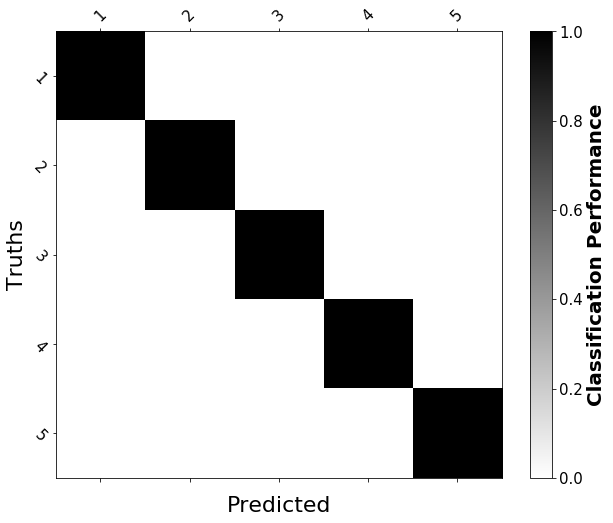

In [90]:
evaluate(testTruth, testPred)

## Questions 


If you are in a group of 1, you will respond to question (1), and **one** other of your choosing (two responses in total).

If you are in a group of 2, you will respond to question (1) and question (2), and **two** others of your choosing (four responses in total). 

A response to a question should take about 100–250 words, and make reference to the data wherever possible.

#### NOTE: you may develope codes or functions in respond to the question, but your formal answer should be added to a separate file.

### Q1
Try discretising the numeric attributes in these datasets and treating them as discrete variables in the na¨ıve Bayes classifier. You can use a discretisation method of your choice and group the numeric values into any number of levels (but around 3 to 5 levels would probably be a good starting point). Does discretizing the variables improve classification performance, compared to the Gaussian na¨ıve Bayes approach? Why or why not?

### Q2
Implement a baseline model (e.g., random or 0R) and compare the performance of the na¨ıve Bayes classifier to this baseline on multiple datasets. Discuss why the baseline performance varies across datasets, and to what extent the na¨ıve Bayes classifier improves on the baseline performance.

### Q3
Since it’s difficult to model the probabilities of ordinal data, ordinal attributes are often treated as either nominal variables or numeric variables. Compare these strategies on the ordinal datasets provided. Deterimine which approach gives higher classification accuracy and discuss why.

### Q4
Evaluating the model on the same data that we use to train the model is considered to be a major mistake in Machine Learning. Implement a hold–out or cross–validation evaluation strategy (you should implement this yourself and do not simply call existing implementations from `scikit-learn`). How does your estimate of effectiveness change, compared to testing on the training data? Explain why. (The result might surprise you!)

### Q5
Implement one of the advanced smoothing regimes (add-k, Good-Turing). Does changing the smoothing regime (or indeed, not smoothing at all) affect the effectiveness of the na¨ıve Bayes classifier? Explain why, or why not.

### Q6
The Gaussian na¨ıve Bayes classifier assumes that numeric attributes come from a Gaussian distribution. Is this assumption always true for the numeric attributes in these datasets? Identify some cases where the Gaussian assumption is violated and describe any evidence (or lack thereof) that this has some effect on the NB classifier’s predictions.